# Computing power spectra

We demonstrate how to calculate angular power spectra, based on the data provided in Lenz, Doré, Lagache (2019).

In [1]:
# %load /Users/dlenz/.jupyter/startup.py
# Standard magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import healpy as hp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Adjust this as needed
datapath = Path('/users/dlenz/Google Drive/PlanckCIB/')

# Load data

In [4]:
freq = '545'

CIB maps, directly converted from MJy/sr to Jy/sr

In [19]:
oddring = hp.read_map(
    datapath.joinpath(f'{freq}/2.5e+20_gp20/cib_oddring.hpx.fits').as_posix(),
    verbose=False) * 1.e6

evenring = hp.read_map(
    datapath.joinpath(f'{freq}/2.5e+20_gp20/cib_evenring.hpx.fits').as_posix(),
    verbose=False) * 1.e6

Masks

In [12]:
mask_bool = hp.read_map(
    datapath.joinpath(f'{freq}/2.5e+20_gp20/mask_bool.hpx.fits').as_posix(),
    verbose=False,
    dtype=bool)

mask_apod = hp.read_map(
    datapath.joinpath(f'{freq}/2.5e+20_gp20/mask_apod.hpx.fits').as_posix(),
    verbose=False,
)

Window functions

In [8]:
windowfuncs = pd.read_csv(
    datapath.joinpath(f'{freq}/2.5e+20_gp20/windowfunctions.csv'),
    comment='#')

In [9]:
windowfuncs.head()

,ell,pixfunc,Bl_16arcmin,Wl_16arcmin,Bl_kernel,Wl_kernel,Bl_native,Wl_native,Bl_eff,Wl_eff,Wl_kappa
0,0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
1,1,1.0,0.999996,0.999996,1.000001,1.000001,0.999999,0.999999,1.0,1.0,1.0
2,2,1.0,0.999988,0.999988,1.000002,1.000002,0.999998,0.999998,1.0,1.0,1.0
3,3,1.0,0.999976,0.999976,1.000005,1.000005,0.999995,0.999995,1.0,1.0,1.0
4,4,1.0,0.999960,0.999960,1.000008,1.000008,0.999992,0.999992,1.0,1.0,1.0


The windowfunctions contain several columns that are useful in working with the data. In general, we use $B_{\ell}$ to indicate beam functions, and $W_{\ell}$ to indicate the product of beam function and HEALPix pixel window function.

For the purpose here, we require the effective window function $W_{\ell}^{\rm eff}$.

We also load the reference power spectrum to compare our results against. This servers as a consistency check, and will also show us discrepancies that result from ignoring the mode coupling matrix $\mathcal{M}_{\ell\ell'}$.

In [10]:
df_cib_auto = pd.read_csv(datapath.joinpath('Cl_CIB_T1T2.csv'), comment='#')

# Calculate the power spectrum

In [20]:
lmax = 1024
ell = np.arange(lmax)

fsky = mask_bool.sum()/mask_bool.size

In [21]:
cl = hp.anafast(
    map1=np.where(mask_bool, oddring, 0.) * mask_apod,
    map2=np.where(mask_bool, evenring, 0.) * mask_apod,
    lmax=lmax-1)

Lastly, we need to correct the power spectrum for the sky cut and for the effective window function.

In [23]:
cl = cl / fsky / windowfuncs['Wl_eff'][:lmax]**2

Text(0, 0.5, '$C_{\\ell}^{TT}\\ [\\rm Jy^2/sr]$')

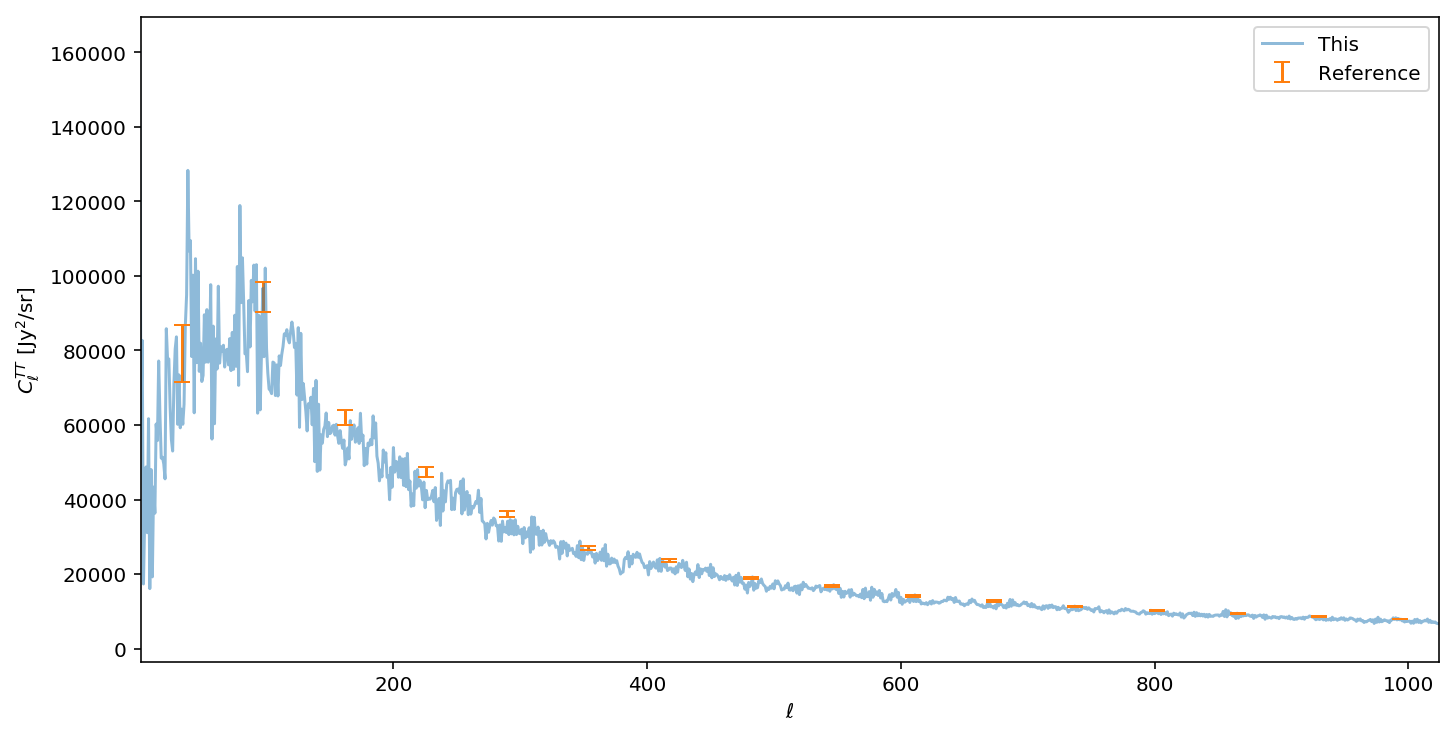

In [28]:
plt.figure(figsize=(10, 5))

# This power spectrum
plt.plot(ell, cl, alpha=0.5, label='This')

plt.errorbar(
    df_cib_auto['ell'],
    df_cib_auto[f"{freq}x{freq}"],
    yerr=df_cib_auto[f"d{freq}x{freq}"],
    ls="None",
    capsize=4,
    label='Reference')

plt.xlim(1, lmax)

# Labels & legend
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}^{TT}\ [\rm Jy^2/sr]$')

This mostly reproduces the power spectrum presented in the paper and in the accompanying `Cl_CIB_T1T2.csv` file, with the remaining difference coming from the mode coupling matrix $\mathcal{M}_{\ell\ell'}$ that `healpy.anafast()` does not correct for.

For a more detailed discussion on this, we refer to the Section on $C_{\ell}$ estimation in Lenz, Doré, Lagache (2019), to [Hivon et al. (2002)](https://arxiv.org/abs/astro-ph/0105302), and to the PolSpice and PyMaster software packages.